In [1]:
import datetime
print datetime.datetime.now()

2019-03-10 11:39:57.998000


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<\style>"))

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
from __future__ import division
import importlib 

import statsmodels.api as sm; from statsmodels.iolib.summary2 import summary_col
import pandas as pd ; pd.set_option("display.max_columns",200);  pd.set_option("display.max_rows",200); 
import numpy as np

In [6]:
store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/edp_2015_final.h5'
reaction_store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/reaction.h5'
Store = pd.HDFStore(store_path)

In [7]:
def load_fisc_i_by_year(year = 2014):
    df_fisci = pd.read_hdf(store_path, 'FISC_INDIVIDU_{}'.format(year))
    return df_fisci
def load_fisc_r_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_REVENU_{}'.format(year))
    return df_fiscr
def load_fisc_l_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_LOGEMENT_{}'.format(year))
    return df_fiscr

def load_df_fiscrevdet_by_year(year = 2015):
    df_fiscrevdet = pd.read_hdf(store_path, 'FISC_REVDET_{}'.format(year))
    return df_fiscrevdet

ir_2014 = importlib.import_module("IRPP_from_scratch_civil_union")
ir_2011 = importlib.import_module("IRPP_from_scratch_civil_union_{}".format(2011))

In [8]:
info_dict = {'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}

## Needed variables

In [9]:
nb_enf_max_for_annalysis = 6

In [10]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])

In [11]:
child_bool_list = ["child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)]
cumulative_child_bool_list = ["cumulative_child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)] 

In [12]:
thrsh_bool_list = ["Threshold_{}".format(thrsh) for thrsh in  threshold_byr_rbg["2011"]]

In [13]:
between_threshold_for_child_rank = ["Between_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
over_threshold_for_child_rank = ["Over_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
children_number =  ["child_{}".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]

In [14]:
interaction_child_between_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, between_threshold_for_child_rank)]
interaction_child_over_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, over_threshold_for_child_rank)]

In [15]:
threshold_byr_rbg

,2011,2014
0,63233,58291
1,73516,63530
2,94451,73806
3,115185,84103
4,135941,94368
5,150684,104633


In [16]:
df_start = pd.read_hdf(u"C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Programme/Réaction offre de travail/hdf/data_step_1_reaction_offre_travail.h5","fisci_fiscr_fiscrevdet")
print(df_start.shape)

(1522346, 362)


In [17]:
df_start["Delta_Rbg"] = df_start.Rbg_2014 - df_start.Rbg_2011
df_start["Delta_rbg_positif"] = (df_start.Delta_Rbg>0).astype("int")
df_start["Delta_rbg_negatif"] = (df_start.Delta_Rbg<0).astype("int")

df_start["Delta_NBPAC"] = df_start.NBPAC_2014 - df_start.NBPAC_2011
df_start["Delta_ZIMPOM"] = df_start.ZIMPOM14_2014 - df_start.ZIMPOM_2011


df_start["Age_wo_squared"] = df_start.Age_wo **2
df_start["Age_me_squared"] = df_start.Age_me ** 2 

df_start["Age_oldest_parent"] = df_start[["Age_me", "Age_wo"]].max(axis = 1)
df_start["Age_oldest_parent_squared"] = df_start.Age_oldest_parent**2

df_start["Parts_fiscales_enfants"] = ir_2011.parts_fiscales_enfants(df_start.NBPAC_2011)
df_start["ZTSAM_10_percent_2014"] =  df_start["ZTSAM_2014"]*0.9
df_start["ZTSAM_10_percent_2014"] =  df_start["ZTSAM_2014"]*0.9
df_start["Irpp_2014"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2014, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2014, df_start.Parts_fiscales_enfants))
df_start["Irpp_2014_plus_10_euros"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants))

df_start["Counterfactual_Irpp_2014"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2014, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2014, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2014_plus_10_euros"] =  np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants))
df_start["Irpp_2011"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2011, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2011, df_start.Parts_fiscales_enfants))
df_start["Irpp_2011_plus_10_euros"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2011"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2011, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2011, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2011_plus_10_euros"] =  np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants))
df_start["MTR_2014"] = np.round((df_start.Irpp_2014_plus_10_euros - df_start.Irpp_2014)/10,3)
df_start["MTR_2011"] = np.round((df_start.Irpp_2011_plus_10_euros - df_start.Irpp_2011)/10,3)
df_start["Counterfactual_MTR_2014"
                     ] =  np.round((df_start.Counterfactual_Irpp_2014_plus_10_euros - df_start.Counterfactual_Irpp_2014)/10,2)
df_start["Counterfactual_MTR_2011"
                     ] = np.round((df_start.Counterfactual_Irpp_2011_plus_10_euros - df_start.Counterfactual_Irpp_2011)/10,2)


In [18]:
#Flatten thresholds
threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis]
flatten_thresholds = np.sort(threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis].values.flatten())
flatten_thresholds_list = list()
for counter in range(len(flatten_thresholds)-1):
    print(flatten_thresholds[counter], flatten_thresholds[counter+1])
    
    thrsh1, thrsh2 = flatten_thresholds[counter], flatten_thresholds[counter+1]
    flatten_thresholds_list.append("Flatten_thresholds_{}_{}".format(thrsh1, thrsh2))
    df_start["Flatten_thresholds_{}_{}".format(thrsh1, thrsh2)] = ((df_start.Rbg_2011>  thrsh1)& (df_start.Rbg_2011< thrsh2))
df_start["Flatten_thresholds_more_then_{}".format( thrsh2)] = (df_start.Rbg_2011> thrsh2).astype("int")
flatten_thresholds_list.append("Flatten_thresholds_more_then_{}".format(thrsh2))

(58291, 63233)
(63233, 63530)
(63530, 73516)
(73516, 73806)
(73806, 84103)
(84103, 94368)
(94368, 94451)
(94451, 104633)
(104633, 115185)
(115185, 135941)
(135941, 150684)


In [19]:



fisici = load_fisc_i_by_year(2014)
df_fisci_child = fisici[fisici.TYPE_FISC.isin(["A", "B", "C", "D", "E", "F", "G", "H"])]
df_fisci_child["Age"] = 2014 - df_fisci_child.ANAIS 
df_fisci_child = df_fisci_child.sort(['ID_FISC_FOY_DIFF', "Age"])


df_fisci_Elder = df_fisci_child.groupby("ID_FISC_FOY_DIFF").last()
df_fisci_Elder["Age_Elder_child"] = df_fisci_Elder.Age
df_fisci_Elder = df_fisci_Elder.reset_index()[["ID_FISC_FOY_DIFF","Age_Elder_child" ]]

df_fisci_Youngest = df_fisci_child.groupby("ID_FISC_FOY_DIFF").first()
df_fisci_Youngest["Age_Youngest_child"] = df_fisci_Youngest.Age
df_fisci_Youngest = df_fisci_Youngest.reset_index()[["ID_FISC_FOY_DIFF","Age_Youngest_child" ]]

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:


df_start["Not_touched_by_reform"] = (df_start.NBPAC_2011 == 0).astype("int")
for nb_enf in range(1,7): ### in modification
    df_start["Not_touched_by_reform".format(nb_enf)
          ] +=((df_start.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])
                *( df_start.NBPAC_2011 == nb_enf)).astype("float")
    
df_start["Delta_Rbg_times_not_touched_reform"] = df_start.Not_touched_by_reform * df_start.Delta_Rbg; df_start.shape

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(1522346, 399)

In [21]:
fisc_logement = load_fisc_l_by_year(2014)
fisc_logement.OCC.value_counts(dropna=False)
fisc_logement["Proprietaire"] = fisc_logement.OCC == "P"
#fisc_logement["CSDEP"] = fisc_logement.CSDEP.replace({"2A": "40", "2B":"40"}).astype("int")

df_start["ID_FISC_LOG_DIFF"] = df_start.ID_FISC_LOG_DIFF_2014
df_start = pd.merge(df_start, fisc_logement, on = "ID_FISC_LOG_DIFF")
df_start.DEP = df_start.DEP.replace({"2A": "96", "2B":"96"}).astype("int")

In [22]:
df_start.shape

(1521762, 436)

###  Income sample selection

In [23]:
df_start.shape

(1521762, 436)

In [24]:
#Nouvelle version ou il faut appartenir à l'intervalle de revenu que sur un seule des deux années
df_start = df_start[((
            (df_start.Rbg_2011>50000)
            &(df_start.Rbg_2011<200000)
        )|(
            (df_start.Rbg_2014>50000)
            & (df_start.Rbg_2014<200000)))];print(df_start.shape)

(451572, 436)


In [25]:
low = 0.02
high = 0.98
quant_df_start = df_start.Delta_Rbg.quantile([low,high])
print(quant_df_start)
df_start = df_start[df_start.Delta_Rbg>quant_df_start.loc[low]]
df_start = df_start[df_start.Delta_Rbg<quant_df_start.loc[high]]
print(df_start.shape)

df_start = df_start[df_start.Rbg_2011>7000]
df_start = df_start[df_start.Rbg_2014>7000]
print(df_start.shape)

0.02   -49793.098
0.98    67614.864
dtype: float64
(433508, 436)
(429622, 436)


In [26]:
df_start = df_start[~(df_start.NBPERSM_2011 == 1 )] #Vire une seule personne dans le ménage
df_start = df_start[~(df_start.NBPERSM_2011 - df_start.NBPAC_2011  == 1 )]  # Vire les parents célibataires
df_start.shape

(414172, 436)

In [27]:
reg_df = df_start[(df_start.Age_wo<65)&(df_start.Age_me<65)] # Vire les papi mamies

In [28]:
reg_df.shape

(267913, 436)

In [29]:
reg_df = reg_df[reg_df.NBPAC_2011.isin(range(nb_enf_max_for_annalysis+1))] #Drop families with more than 6 children
reg_df.shape

(267806, 436)

In [30]:
# Drop non maried families
fisici = load_fisc_i_by_year(2014)
id_foy_diff = reg_df.ID_FISC_FOY_DIFF
fisci_2 = fisici[fisici.ID_FISC_FOY_DIFF.isin(id_foy_diff)]
print(fisci_2.CIDECI.value_counts())
to_drop = fisci_2.CIDECI.isin([ 'C','D', 'V', 'O'])
reg_df = reg_df[~reg_df.ID_FISC_FOY_DIFF.isin(to_drop)]
reg_df.shape

M    432365
A    384859
O     36374
C     24599
D      8693
V      1052
dtype: int64


(267806, 436)

In [31]:
reg_df_same_NBPAC = reg_df[(reg_df.NBPAC_2011 == reg_df.NBPAC_2014)]
reg_df_same_NBPAC.shape

(193555, 436)

In [32]:
### Add children age
reg_df_same_NBPAC = reg_df_same_NBPAC.merge(df_fisci_Youngest, on = "ID_FISC_FOY_DIFF", how = "left")
reg_df_same_NBPAC = reg_df_same_NBPAC.merge(df_fisci_Elder, on = "ID_FISC_FOY_DIFF",  how = "left")
reg_df_same_NBPAC.Age_Elder_child.fillna(0, inplace = True)
reg_df_same_NBPAC.Age_Youngest_child.fillna(0, inplace = True)
reg_df_same_NBPAC.shape

(193555, 438)

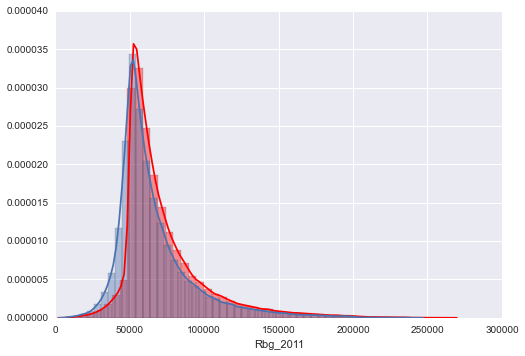

In [33]:
import seaborn as sns
sns.distplot(reg_df_same_NBPAC.Rbg_2014, color = "r")
sns.distplot(reg_df_same_NBPAC.Rbg_2011)

In [34]:
df = reg_df_same_NBPAC

### Triple diff

In [35]:
(df.ZVALM_2011<50).value_counts()

True     144841
False     48714
dtype: int64

In [36]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , reg_df_same_NBPAC)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     312.2
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:42:50   Log-Likelihood:            -2.1330e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193524   BIC:                         4.266e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

### Flatten thresholds

In [37]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     312.2
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:42:51   Log-Likelihood:            -2.1330e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193524   BIC:                         4.266e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [38]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df.query("ZVALM_2011<=50"))
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     221.5
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:42:53   Log-Likelihood:            -1.5896e+06
No. Observations:              145050   AIC:                         3.179e+06
Df Residuals:                  145019   BIC:                         3.180e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [39]:
hardcoded_over = ["Over_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]
hardcoded_between = ["Between_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]

for child in range(1,7):
    df["Over_{}_X_{}_child".format(child,child)] = df["Over_threshold_{}_child".format(child)] * (df["NBPAC_2011"]==child)
    df["Between_{}_X_{}_child".format(child,child)] = df["Between_threshold_{}_child".format(child)] * (df["NBPAC_2011"]==child)

In [40]:
df["Proprietaire"] = df.OCC == "P"

In [41]:
df.DATACHEV = df.DATACHEV.clip(1900,2012)

In [42]:
df["House_age"] = 2012 - df.DATACHEV

In [43]:
df["Social_housing"] = ~df.HLMSEM.isnull()

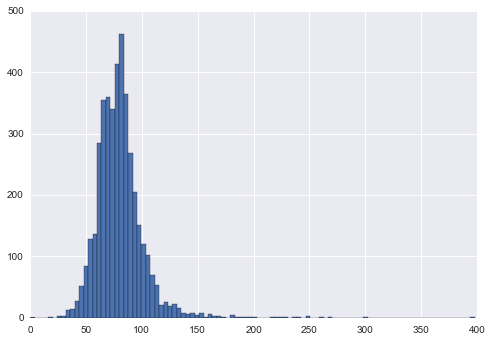

In [44]:
df.query("Social_housing").SURFTOT.hist(bins = 100)

In [45]:
df.CNE.value_counts().head(20)

63     1565
109    1360
115    1218
113    1218
4      1184
555    1132
118    1117
88     1109
114    1004
69      990
33      979
112     979
51      970
1       952
117     951
7       924
116     915
48      912
120     884
12      884
dtype: int64

In [46]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(hardcoded_over + hardcoded_between)),
        df)
fit1 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + hardcoded_over + hardcoded_between)),
        df)
fit2 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join( flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit3 = m.fit(cov_type="HC1")




m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join( 
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_4 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(
                  children_number[1:] + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("NBPAC_2011>=1"))
fit_5 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_6 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)


fit_6_1 = m.fit(cov_type="HC1")

m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared +Age_Elder_child+Age_Youngest_child\
                                           +Proprietaire +SURFTOT + Social_housing + House_age ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_7 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(CNE) ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_8 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(CNE)+ C(DEP) ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_9 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"))
fit_10 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)"))
fit_11 = m.fit(cov_type="HC1")

m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==0)"))
fit_12 = m.fit(cov_type="HC1")



#print(summary_col([fit1, fit2,fit3, fit_4],model_names =None, stars = True))



In [47]:
summary = summary_col([fit1, fit2,fit3, fit_4, fit_5, fit_6, fit_6_1, fit_7, fit_8, fit_9, fit_10, fit_11, fit_12], stars = True,float_format='%.2f',
                  info_dict=info_dict,
                model_names = ["Only_treatment_var","Treatmt_var_w_child_var", "Treatment_var_w_income_thrsh_var", "Triple_diff", 
                               "Triple_diff_w_child_only", "Tripl_age_parents", "Triple_age", "Triple_control_local", "Triple_countrol_housing","Triple_control_local_dep", 
                               "Triple_no_othr_income", "Triple_noi_positive_delta","Triple_noi_negative_delta" ])

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:376

In [48]:
import copy
summary_save = summary

In [49]:

summary = copy.copy(summary_save)

In [50]:
code_communes = list(df.CNE.value_counts().sort_index().index)
code_deps = list(df.DEP.value_counts().sort_index().index)



df_table_reg = summary.tables[0]

loc_indexes = list()
for com in ["C(CNE)[T.{}]".format(code_com) for code_com in code_communes[1:]]: #First code taken as reference
    loc_indexes.append(df_table_reg.index.get_loc(com))
for com in ["C(DEP)[T.{}]".format(code_dep) for code_dep in code_deps[1:]]: #First code taken as reference
    loc_indexes.append(df_table_reg.index.get_loc(com))
loc_indexes = np.array(loc_indexes)



df_table_reg = df_table_reg.reset_index()

to_drop_indexes = df_table_reg.iloc[loc_indexes+1].index
df_table_reg = df_table_reg.drop(to_drop_indexes)
df_table_reg = df_table_reg.set_index("index")
df_table_reg = df_table_reg.drop(["C(CNE)[T.{}]".format(code_com) for code_com in code_communes]+["C(DEP)[T.{}]".format(code_dep) for code_dep in code_deps[1:]])
head_df = df_table_reg.iloc[:-2]
head_df.loc["Code_departement"] = [""]*9+["   X"]*1+[""]*3
head_df.loc["Code_commune"] = [""]*8+["  X"]*2+ [""]*3
df_table_reg = head_df.append(df_table_reg.iloc[-2:]) 
summary.tables = [df_table_reg]
print(summary)


                                         Only_treatment_var Treatmt_var_w_child_var Treatment_var_w_income_thrsh_var Triple_diff Triple_diff_w_child_only Tripl_age_parents  Triple_age Triple_control_local Triple_countrol_housing Triple_control_local_dep Triple_no_othr_income Triple_noi_positive_delta Triple_noi_negative_delta
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_Elder_child                                                                                                                                                             -121.70***  -120.43***           -118.72***              -115.68***               -61.54***             29.37                     -26.88                   
               

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
from collections import OrderedDict

In [52]:
regression_list_name_by_sample_condition = OrderedDict([("OLS","(Age_wo>-1)"), 
                                           ( "Age_oldest<=50"," (Age_oldest_parent<=50)"), 
                                            ("Age_oldest>50", " (Age_oldest_parent>50)")])

regression_fit_list = list()
regression_name_list = list()





m = sm.OLS.from_formula("(Delta_Rbg)~   {} ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
regression_fit_list.append(fit) ; regression_name_list.append("OLS")

for name,condition in regression_list_name_by_sample_condition.items():


    m = sm.OLS.from_formula("(Delta_Rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared  ".format(
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df.query(" {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit) ; regression_name_list.append(name)
    
for name,condition in regression_list_name_by_sample_condition.items():


    m = sm.OLS.from_formula("(Delta_Rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared  ".format(
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list)),
            df.query(" {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit) ; regression_name_list.append(name+"_No_treatment_dummies")


print(summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list))


                                             OLS I       OLS II   Age_oldest<=50 I Age_oldest>50 I OLS_No_treatment_dummies I Age_oldest<=50_No_treatment_dummies I Age_oldest>50_No_treatment_dummies I
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_oldest_parent                                     -206.13***  -1611.20***      -2244.73***     -171.61***                 -1637.16***                           -2201.30***                         
                                                      (44.16)     (107.76)         (506.93)        (44.34)                    (107.76)                              (507.85)                            
Age_oldest_parent_squared                             0.31        17.47***         16.91***        -0.06                      17.78***                              16.47***                       

### By type of income

In [53]:
household_income_var = ["ZSALM", "ZCHOM", "ZRSTM","ZRAGM","ZRICM","ZRNCM",]
for var in household_income_var:
        df["Delta_{}".format(var)] = df["{}_2014".format(var)] - df["{}_2011".format(var)]

In [54]:
### TODO: RLM (on all tables)


individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI', # Salaire, chomage, retraite
                             'YRAGI', 'YBICI', 'YBNCI',# Benefices Agricoles, Benefices industriels et commerciaux, Benefices non commerciaux
                            ] 
#From individualized income
for parent in ["me", "wo"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_{}_2014".format(var,parent)] - df["{}_{}_2011".format(var, parent)]

regression_fit_list = list()
regression_name_list = list()
for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df.query(" {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit)

    for parent in ["me", "wo"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df.query(" {} ".format(condition)))
        fit = m.fit(cov_type="HC1")
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict))





                                          Delta_ZSALM  Delta_YSALI_me Delta_YSALI_wo Delta_ZCHOM  Delta_YCHOI_me Delta_YCHOI_wo  Delta_ZRSTM  Delta_YRSTI_me Delta_YRSTI_wo Delta_ZRAGM Delta_YRAGI_me Delta_YRAGI_wo Delta_ZRICM Delta_YBICI_me Delta_YBICI_wo Delta_ZRNCM  Delta_YBNCI_me Delta_YBNCI_wo
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                 457156.30*** 366930.37***   108846.88***   -52521.87*** -32137.81***   -14944.84***   -237719.49*** -215042.59***  -68883.77***   -7210.71**  -2488.11       -3065.72       10440.06*   17578.37***    -4611.44       -40849.50*** -37378.74***   -2944.47      
                                          (19584.35)   (18780.25)     (11551.19)     (7225.67)    (624

In [55]:
###For Delta ZIMPOM
for child in range(1, nb_enf_max_for_annalysis+1):
    df[
        "Interactions_rbg_child{}_between".format(child)
            ] = df.eval("Delta_Rbg*child_{}*Between_threshold_{}_child".format(child, child))
    df["Interactions_child{}_between".format(child)
                     ] = df.eval("child_{}*Between_threshold_{}_child".format(child, child))
    df["Interactions_rbg_child{}_over".format(child)
                     ] = df.eval("Delta_Rbg*child_{}*Over_threshold_{}_child".format(child, child))
    df["Interactions_child{}_over".format(child)
                     ] = df.eval("child_{}*Over_threshold_{}_child".format(child, child))
interactions_rbg_between = ["Interactions_rbg_child{}_between".format(child) for child in range(1,7)]
interactions_child_between = ["Interactions_child{}_between".format(child) for child in range(1,7)]
interactions_rbg_over = ["Interactions_rbg_child{}_over".format(child) for child in range(1,7)]
interactions_child_over = ["Interactions_child{}_over".format(child) for child in range(1,7)]


### Extensive margin

In [56]:
df["Wo_start_working"] = (
    ((df["YSALI_wo_2011"]+df["YBICI_wo_2011"]+df["YBNCI_wo_2011"])<2000)
    &((df["YSALI_wo_2014"]+df["YBICI_wo_2014"]+df["YBNCI_wo_2014"])>10000)
    ).astype("int")

df["Me_start_working"] = (
    ((df["YSALI_me_2011"]+df["YBICI_me_2011"]+df["YBNCI_me_2011"])<2000)
    &((df["YSALI_me_2014"]+df["YBICI_me_2014"]+df["YBNCI_me_2014"])>10000)
    ).astype("int")

print df["Wo_start_working"].value_counts(normalize = True)
print df["Me_start_working"].value_counts(normalize = True)

0    0.979964
1    0.020036
dtype: float64
0    0.990297
1    0.009703
dtype: float64


In [57]:
df["Wo_stop_working_not_retired"] = (
    ((df["YSALI_wo_2011"]+df["YBICI_wo_2011"]+df["YBNCI_wo_2011"])>10000)
    &((df["YSALI_wo_2014"]+df["YBICI_wo_2014"]+df["YBNCI_wo_2014"])<2000)
    &(reg_df_same_NBPAC["YRSTI_wo_2014"]<6000)
    ).astype("int")

df["Me_stop_working_not_retired"] = (
    ((df["YSALI_me_2011"]+df["YBICI_me_2011"]+df["YBNCI_me_2011"])>10000)
    &((df["YSALI_me_2014"]+df["YBICI_me_2014"]+df["YBNCI_me_2014"])>2000)
    &(reg_df_same_NBPAC["YRSTI_me_2014"]<6000)
    ).astype("int")
print df["Wo_stop_working_not_retired"].value_counts(normalize = True)
print df["Me_stop_working_not_retired"].value_counts(normalize = True)

0    0.935491
1    0.064509
dtype: float64
1    0.770122
0    0.229878
dtype: float64


In [58]:
df["Wo_get_retired"] = ((df["YRSTI_wo_2011"]<2000) & (df["YRSTI_wo_2014"]>6000)).astype("int")

df["Me_get_retired"] = (((df["YRSTI_me_2011"]<2000) & (df["YRSTI_me_2014"]>6000))                               
                                           ).astype("int")
print df["Wo_get_retired"].value_counts(normalize = True)
print df["Me_get_retired"].value_counts(normalize = True)


0    0.970298
1    0.029702
dtype: float64
0    0.955191
1    0.044809
dtype: float64


In [59]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_men = m.fit(cov_type="HC1")
summary = fit_men.summary(); print(summary)

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_wo = m.fit(cov_type="HC1")
summary = fit_wo.summary(); print(summary)





                            OLS Regression Results                            
Dep. Variable:         Me_get_retired   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     297.1
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:45:47   Log-Likelihood:                 41839.
No. Observations:              192640   AIC:                        -8.362e+04
Df Residuals:                  192610   BIC:                        -8.331e+04
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [60]:
regression_fit_list = list()
for var in ["start_working", "stop_working_not_retired","get_retired" ]:
    for sex in ["Me", "Wo"]:
        m = sm.OLS.from_formula("({}_{})".format(sex, var)+ "~   {}  + Age_wo + Age_me+ I(Age_wo_squared/10**4) + I(Age_me_squared/10**4)+I(Age_Elder_child/10**4)".format(
                       ' + '.join(children_number[:4] 
                            + children_number[:4] + flatten_thresholds_list
                            + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                            df.query("(NBPAC_2011<=4)"))
        fit = m.fit(cov_type="HC1")
        summary = fit_men.summary()
        regression_fit_list.append(fit)
print(summary_col(regression_fit_list, stars = True,float_format='%.4f',
                  info_dict=info_dict))



                                          Me_start_working Wo_start_working Me_stop_working_not_retired Wo_stop_working_not_retired Me_get_retired Wo_get_retired
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                 0.0877***        0.1316***        -1.1587***                  -0.0323**                   0.3897***      0.3532***     
                                          (0.0100)         (0.0104)         (0.0315)                    (0.0139)                    (0.0133)       (0.0118)      
Flatten_thresholds_58291_63233[T.True]    -0.0090***       -0.0140***       0.0209***                   0.0085***                   -0.0005        -0.0018       
                                          (0.0007)         (0.0010)         (0.0030)                    (0.0021)                    (0.0017)       (0.0015)      
Flatten_thresholds_63233_63

In [61]:
#Without treatment variables
regression_fit_list = list()
for var in ["start_working", "stop_working_not_retired","get_retired" ]:
    for sex in ["Me", "Wo"]:
        m = sm.OLS.from_formula("({}_{})".format(sex, var)+ "~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
                       ' + '.join(children_number[:4] + flatten_thresholds_list)),
                        df.query("(NBPAC_2011<=4)"))
        fit = m.fit(cov_type="HC1")
        summary = fit_men.summary()
        regression_fit_list.append(fit)
print(summary_col(regression_fit_list, stars = True,float_format='%.4f',
                  info_dict=info_dict))



                                         Me_start_working Wo_start_working Me_stop_working_not_retired Wo_stop_working_not_retired Me_get_retired Wo_get_retired
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                0.0852***        0.1311***        -1.1452***                  -0.0328**                   0.3988***      0.3562***     
                                         (0.0100)         (0.0103)         (0.0313)                    (0.0139)                    (0.0134)       (0.0119)      
Flatten_thresholds_58291_63233[T.True]   -0.0088***       -0.0126***       0.0193***                   0.0087***                   -0.0008        -0.0020       
                                         (0.0006)         (0.0009)         (0.0028)                    (0.0020)                    (0.0015)       (0.0013)      
Flatten_thresholds_63233_63530[T.

In [62]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit = m.fit()
summary = fit.summary(); print(summary)

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit_wo = m.fit()
summary = fit_wo.summary(); print(summary)


                            OLS Regression Results                            
Dep. Variable:         Me_get_retired   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     882.9
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:46:21   Log-Likelihood:                 41839.
No. Observations:              192640   AIC:                        -8.362e+04
Df Residuals:                  192610   BIC:                        -8.331e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [63]:
print(summary_col([fit, fit_wo], stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                          Me_get_retired Wo_get_retired
-----------------------------------------------------------------------
Intercept                                 0.3897***      0.3532***     
                                          (0.0114)       (0.0095)      
Between_threshold_1_child[T.True]         -0.0005        -0.0018       
                                          (0.0017)       (0.0014)      
Between_threshold_2_child[T.True]         0.0188***      0.0079        
                                          (0.0062)       (0.0051)      
Between_threshold_3_child[T.True]         0.0045         0.0052        
                                          (0.0081)       (0.0067)      
Between_threshold_4_child[T.True]         -0.0015        -0.0014       
                                          (0.0025)       (0.0021)      
Between_threshold_5_child[T.True]         -0.0163        -0.0171       
                                          (0.0232)       (0.019

### ZIMPOM

(193555, 500)
(193555, 500)


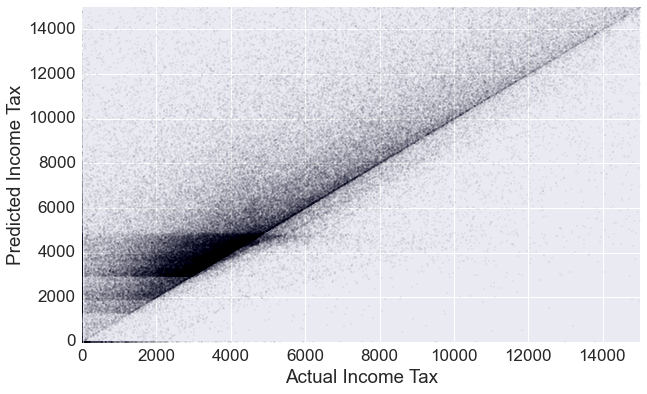

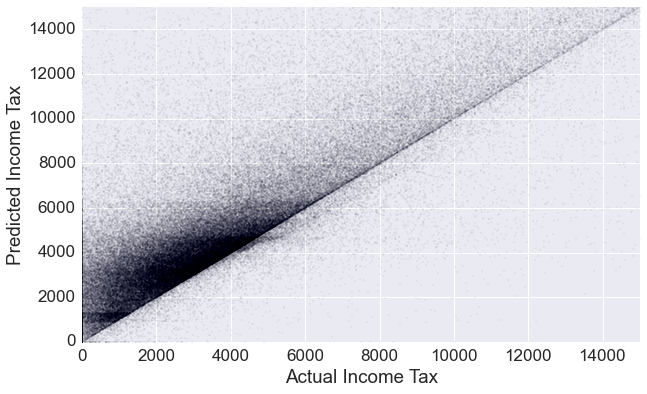

In [64]:
sns.set(font_scale = 1.7)
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,6))
plt.scatter(df_temp.ZIMPOM14_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,6))
plt.scatter(df_temp.ZIMPOM_2011,df_temp.Irpp_2011, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

In [65]:
regression_delta_zimpom_formula = " {}  + Not_touched_by_reform*C(NBPAC_2011)- Not_touched_by_reform-C(NBPAC_2011)"\
"+ Delta_Rbg_times_not_touched_reform/C(NBPAC_2011)-Delta_Rbg_times_not_touched_reform"\
"-1".format(
        ' + '.join( interactions_child_over+ interactions_child_between+interactions_rbg_over+interactions_rbg_between))

In [66]:


df["Not_touched_by_reform"] = (df.NBPAC_2011 == 0).astype("int")
for nb_enf in range(1,7): ### in modification
    df["Not_touched_by_reform".format(nb_enf)
          ] +=((df.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])
                *( df.NBPAC_2011 == nb_enf)).astype("float")

In [67]:
m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df)
fit1 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVALM_2011<50)"))
fit2 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)"))
fit3 = m.fit()


m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"))
fit4 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"\
                                 "&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)"\
                                 "&(ZVALM_2011<50)" \
                                ))
fit5 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query(("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)"))
                        )
fit6 = m.fit()


m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query(("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==0)"))
                        )
fit7 = m.fit()



In [68]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").Delta_ZIMPOM.mean()* 0.128

187.35313193021668

In [69]:
print(summary_col([fit1, fit2,fit3, fit4, fit5, fit6, fit7], stars = True,float_format='%.3f',
                  info_dict=info_dict))


                                                      Delta_ZIMPOM I Delta_ZIMPOM II Delta_ZIMPOM III Delta_ZIMPOM IIII Delta_ZIMPOM IIIII Delta_ZIMPOM IIIIII Delta_ZIMPOM IIIIIII
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interactions_child1_over                              1224.397***    1054.033***     1220.851***      1182.230***       1138.669***        908.510***          907.230***          
                                                      (39.269)       (34.399)        (40.883)         (35.480)          (31.176)           (53.015)            (80.654)            
Interactions_child2_over                              1987.648***    1815.497***     1978.035***      2043.818***       1859.081***        1525.396***         1727.364***         
                                                      (30.691)       (27.459)        (32.125)      

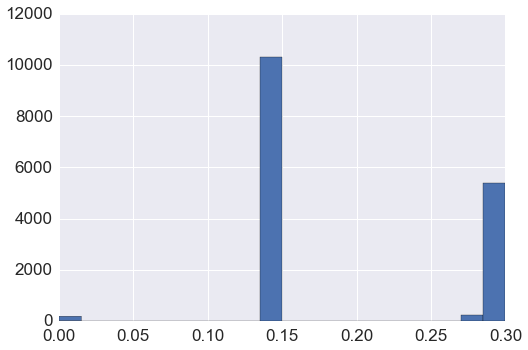

In [70]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").MTR_2014.hist(bins = 20)

In [71]:
df["Delta_Rbg_times_not_touched_reform"] = df.Not_touched_by_reform * df.Delta_Rbg

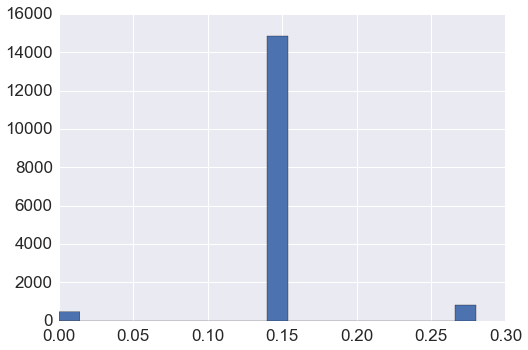

In [72]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").Counterfactual_MTR_2011.hist(bins = 20)

In [73]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between)),
       df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)").sample(frac = 1))
fit = m.fit()
fit.conf_int()


summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3097.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:46:52   Log-Likelihood:            -6.2713e+05
No. Observations:               69144   AIC:                         1.254e+06
Df Residuals:                   69113   BIC:                         1.255e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [74]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     6083.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:46:55   Log-Likelihood:            -1.8898e+06
No. Observations:              193555   AIC:                         3.780e+06
Df Residuals:                  193529   BIC:                         3.780e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [75]:
df.Between_thresholds.head()

0    1
1    0
2    0
3    0
4    0
Name: Between_thresholds, dtype: int32

In [76]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between))
                                                                                        , df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     4724.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:46:56   Log-Likelihood:            -7.9791e+05
No. Observations:               87773   AIC:                         1.596e+06
Df Residuals:                   87741   BIC:                         1.596e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [77]:

df_expetcted_values = pd.DataFrame()
df_expetcted_values.loc["Over_lumpsum_1","expected_same_rbg2"] = 836
df_expetcted_values.loc["Over_lumpsum_2","expected_same_rbg2"] = 836 * 2 
df_expetcted_values.loc["Over_lumpsum_3","expected_same_rbg2"] = 836 * 4 
df_expetcted_values.loc["Over_lumpsum_4","expected_same_rbg2"] = 836 * 6
df_expetcted_values.loc["Over_lumpsum_5","expected_same_rbg2"] = 836 * 8

df_expetcted_values.loc["Over_lumpsum_1","expected_same_rbg"] = df.query("Interactions_child1_over == 1").Irpp_2011.mean() - df.query("Interactions_child1_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_2","expected_same_rbg"] = df.query("Interactions_child2_over == 1").Irpp_2011.mean() - df.query("Interactions_child2_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_3","expected_same_rbg"] = df.query("Interactions_child3_over == 1").Irpp_2011.mean() - df.query("Interactions_child3_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_4","expected_same_rbg"] = df.query("Interactions_child4_over == 1").Irpp_2011.mean() - df.query("Interactions_child4_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_5","expected_same_rbg"] = df.query("Interactions_child5_over == 1").Irpp_2011.mean() - df.query("Interactions_child5_over == 1").Counterfactual_Irpp_2011.mean() 



df_expetcted_values.loc["Between_lumpsum_1","expected_same_rbg"] =30
df_expetcted_values.loc["Between_lumpsum_2","expected_same_rbg"] = 836 * 2 
df_expetcted_values.loc["Between_lumpsum_3","expected_same_rbg"] = 836 * 4 
df_expetcted_values.loc["Between_lumpsum_4","expected_same_rbg"] = 836 * 6
df_expetcted_values.loc["Between_lumpsum_5","expected_same_rbg"] = 836 * 8



df_expetcted_values.loc["Over_lumpsum_1","expected"] = 836
df_expetcted_values.loc["Over_lumpsum_2","expected"] = 836 * 2 
df_expetcted_values.loc["Over_lumpsum_3","expected"] = 836 * 4 
df_expetcted_values.loc["Over_lumpsum_4","expected"] = 836 * 6
df_expetcted_values.loc["Over_lumpsum_5","expected"] = 836 * 8


df_expetcted_values.loc["Over_MTR_1", "expected"] = df.query("Interactions_child1_over == 1").MTR_2014.mean() 
df_expetcted_values.loc["Over_MTR_2", "expected"] = df.query("Interactions_child2_over == 1").MTR_2014.mean()
df_expetcted_values.loc["Over_MTR_3", "expected"] = df.query("Interactions_child3_over == 1").MTR_2014.mean() 
df_expetcted_values.loc["Over_MTR_4", "expected"] = df.query("Interactions_child4_over == 1").MTR_2014.mean()
df_expetcted_values.loc["Over_MTR_5", "expected"] = df.query("Interactions_child5_over == 1").MTR_2014.mean()


df_expetcted_values.loc["Between_MTR_1", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 1)").MTR_2014.mean() 
df_expetcted_values.loc["Between_MTR_2", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 2)").MTR_2014.mean()
df_expetcted_values.loc["Between_MTR_3", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 3)").MTR_2014.mean() 
df_expetcted_values.loc["Between_MTR_4", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 4)").MTR_2014.mean()
df_expetcted_values.loc["Between_MTR_5", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 5)").MTR_2014.mean()

df_expetcted_values.loc["Not_touched_by_reform", "expected"] = 18
df_expetcted_values.loc["Not_touched_by_reform_MTR", "expected"] = df.query("Not_touched_by_reform == True").MTR_2014.mean()






df_expetcted_values.loc["Over_lumpsum_1","expected"] = (df.query("Interactions_child1_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child1_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_2","expected"] = (df.query("Interactions_child2_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child2_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_3","expected"] = (df.query("Interactions_child3_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child3_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_4","expected"] = (df.query("Interactions_child4_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child4_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_5","expected"] = (df.query("Interactions_child5_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child5_over == 1").Irpp_2011).mean()


df_expetcted_values.loc["Over_MTR_1", "expected"] = df.query("Interactions_child1_over == 1").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Over_MTR_2", "expected"] = df.query("Interactions_child2_over == 1").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Over_MTR_3", "expected"] = df.query("Interactions_child3_over == 1").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Over_MTR_4", "expected"] = df.query("Interactions_child4_over == 1").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Over_MTR_5", "expected"] = df.query("Interactions_child5_over == 1").Counterfactual_MTR_2011.mean()


df_expetcted_values.loc["Between_MTR_1", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 1)").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Between_MTR_2", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 2)").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Between_MTR_3", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 3)").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Between_MTR_4", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 4)").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Between_MTR_5", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 5)").Counterfactual_MTR_2011.mean()

df_expetcted_values.loc["Not_touched_by_reform", "expected"] = 18
df_expetcted_values.loc["Not_touched_by_reform_MTR", "expected"] = df.query("Not_touched_by_reform == True").Counterfactual_MTR_2014.mean()








# df_expetcted_values["OLS"] = fit.params.values
# df_expetcted_values["Delta_OLS"] = df_expetcted_values["OLS"]-df_expetcted_values["expected"]

In [78]:
fit.params.describe

<bound method Series.describe of Interactions_child1_over                     1138.668897
Interactions_child2_over                     1859.081007
Interactions_child3_over                     3184.281197
Interactions_child4_over                     5119.359370
Interactions_child5_over                     6920.581010
Interactions_child6_over                     6154.763135
Interactions_rbg_child1_over                    0.249042
Interactions_rbg_child2_over                    0.275315
Interactions_rbg_child3_over                    0.304584
Interactions_rbg_child4_over                    0.327581
Interactions_rbg_child5_over                    0.404251
Interactions_rbg_child6_over                    0.388969
Interactions_rbg_child1_between                 0.183153
Interactions_rbg_child2_between                 0.222697
Interactions_rbg_child3_between                 0.230030
Interactions_rbg_child4_between                 0.233436
Interactions_rbg_child5_between                 0.22522

In [79]:

ir_2011.ir_avec_plafond_qf_enfant(np.array([85000]), np.array([0.5]))-  ir_2014.ir_avec_plafond_qf_enfant(np.array([85000]), np.array([0.5]))

array([-680.97])

In [80]:
df_expetcted_values

,expected_same_rbg2,expected_same_rbg,expected
Over_lumpsum_1,836,-669.766751,1267.204433
Over_lumpsum_2,1672,-1488.925320,2065.162118
Over_lumpsum_3,3344,-3111.518390,2824.891414
Over_lumpsum_4,5016,-4719.088800,3658.975696
Over_lumpsum_5,6688,-6285.332310,4851.605929
Between_lumpsum_1,NaN,30.000000,NaN
Between_lumpsum_2,NaN,1672.000000,NaN
Between_lumpsum_3,NaN,3344.000000,NaN
Between_lumpsum_4,NaN,5016.000000,NaN
Between_lumpsum_5,NaN,6688.000000,NaN


In [81]:

# df["Treatment_0_2011"] = False * df.shape[0]



# df["Treatment_1_2011"] = False * df.shape[0]


# df["Treatment_2_2011"] = False * df.shape[0]
# for child in range(1,7):

#     df["Treatment_1_2011"] += (df.NBPAC_2011 == child) * df["Between_threshold_{}_child".format(child)]
    

#     df["Treatment_2_2011"] += (df.NBPAC_2011 == child) * df["Over_threshold_{}_child".format(child)]
# df["Treatment_1_2011"] = df["Treatment_1_2011"].astype("bool")
# df["Treatment_2_2011"] = df["Treatment_2_2011"].astype("bool")
# df["Treatment_0_2011"] = ~(df.Treatment_1_2011 |df_start.Treatment_2_2011)

# print(df.query("Treatment_1_2011==1").Counterfactual_MTR_2011.mean())
# print(df.query("Between_thresholds==1").Counterfactual_MTR_2011.mean())

### Graphs MTR

In [82]:
import matplotlib

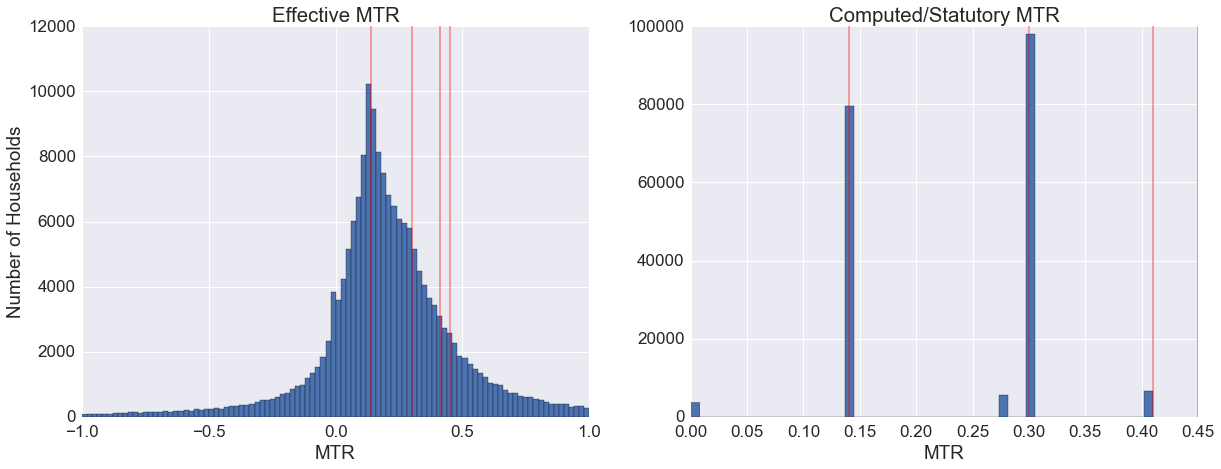

In [83]:
sns.set(font_scale = 1.7)
df["Real_MTR_from_Zimpom"] = (df.ZIMPOM14_2014 - df.ZIMPOM_2011)/(df.Rbg_2014 - df.Rbg_2011)
plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
df.query("(-1<Real_MTR_from_Zimpom<1)").Real_MTR_from_Zimpom.hist(bins = 100)
y_min, y_max = plt.ylim()
plt.axvline(0.3,  color = 'r',alpha = 0.4)
plt.axvline(0.14, color = 'r',alpha = 0.4)
plt.axvline(0.41, color = 'r',alpha = 0.4)
plt.axvline(0.45, color = 'r',alpha = 0.4)
plt.ylabel("Number of Households")
plt.xlabel("MTR")
plt.title("Effective MTR")
plt.subplot(1,2,2)
plt.title("Computed/Statutory MTR")
df.MTR_2014.hist(bins = 51)
plt.axvline(0.3,  color = 'r',alpha = 0.4)
plt.axvline(0.14, color = 'r',alpha = 0.4)
plt.axvline(0.41, color = 'r',alpha = 0.4)
plt.axvline(0.45, color = 'r',alpha = 0.4)
plt.xlabel("MTR")

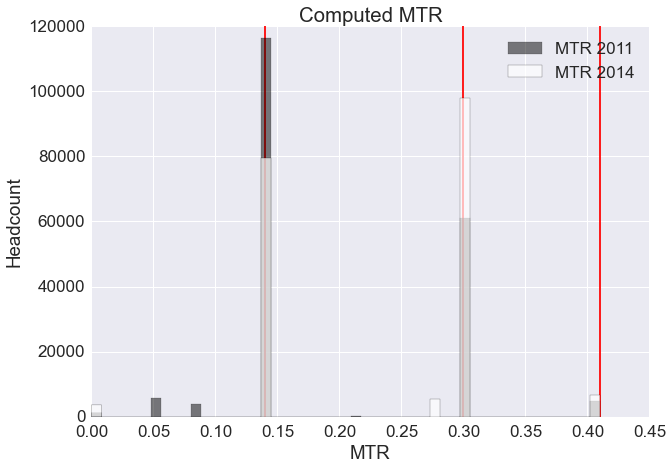

In [84]:
#Transformer en barplot plutpot qu'en hist
import matplotlib as mpl
import matplotlib.patches as mpatches

# mpl.rcParams["hatch.color"] = "white"
# mpl.rcParams['hatch.linewidth'] = 2

fig,ax = plt.subplots(figsize = (10,7))

plt.title("Computed MTR")
df.MTR_2011.hist(bins = 51, color = (0,0,0,0), alpha=0.5, zorder = 3, label = "MTR 2011")
#df.MTR_2011.hist(bins = 51, color = "k", alpha=0.7, zorder = 1, )

plt.axvline(0.3,  color = 'red',)
plt.axvline(0.14, color = 'red',)
plt.axvline(0.41, color = 'red',)


plt.title("Computed MTR")
df.MTR_2014.hist(bins = 51, color = "w", alpha=0.7, zorder = 4, label = "MTR 2014")

#ax.set_xticks([0, 0.055, 0.14, 0.28, 0.3, 0.41])
plt.xlabel("MTR")
plt.ylabel("Headcount")
plt.legend()


In [85]:
df.MTR_2011.value_counts().iloc[:7]

0.140    116381
0.300     60927
0.055      5883
0.410      4923
0.083      2220
0.082      1784
0.000      1269
dtype: int64

In [86]:
5.5*1.5

8.25

In [87]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts().iloc[:8]); df_mtr_2011
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)]

In [88]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts().iloc[:8]); print(df.MTR_2011).value_counts().head(11)
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.MTR_2014).value_counts().iloc[:5]); df_mtr_2014
pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"]).fillna(0)

0.140    116381
0.300     60927
0.055      5883
0.410      4923
0.083      2220
0.082      1784
0.000      1269
0.210       116
0.191         4
0.065         3
0.063         3
dtype: int64


,02011,02014
0.000,1269,3653
0.055,5883,0
0.083,4004,0
0.140,116381,79607
0.210,116,0
0.280,0,5597
0.300,60927,97947
0.410,4923,6679


In [89]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts(normalize = True).iloc[:8]); df_mtr_2011
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.MTR_2014).value_counts(normalize = True).iloc[:5]); df_mtr_2014
df_mtr_merged = pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"])
df_mtr_merged.loc["Total"] = df_mtr_merged.sum(); df_mtr_merged.fillna(0)

,02011,02014
0.0,0.006556,0.018873
0.055,0.030394,0.000000
0.083,0.020687,0.000000
0.14,0.601281,0.411289
0.21,0.000599,0.000000
0.28,0.000000,0.028917
0.3,0.314779,0.506042
0.41,0.025435,0.034507
Total,0.999731,0.999628


In [90]:
df["Distance_to_treatment_2"]  = 0
for child in range(1,nb_enf_max_for_annalysis+1):
    df["Distance_to_treatment_2"] += (df["Over_threshold_{}_child".format(child)] * df[child_bool_list[child-1]] 
                                     * ((threshold_byr_rbg["2011"].iloc[child-1]) - df.Rbg_2011))
df["Distance_to_treatment_2"] = np.abs(df["Distance_to_treatment_2"])

In [91]:
76034-94451

-18417

In [92]:
df["Distance_to_treatment_1"]  = 0
for child in [2]:
    df["Distance_to_treatment_1"] += (df[child_bool_list[child-1]]*(df["Over_threshold_{}_child".format(child)])
                                     * (threshold_byr_rbg["2011"].iloc[child-1] - df.Rbg_2011))
df["Distance_to_treatment_1"] = np.abs(df["Distance_to_treatment_1"])




df["Distance_to_treatment_2"]  = 0
for child in range(1,nb_enf_max_for_annalysis+1):
    df["Distance_to_treatment_2"] += (df[child_bool_list[child-1]]*(df["Over_threshold_{}_child".format(child)])
                                     * (threshold_byr_rbg["2011"].iloc[child-1] - df.Rbg_2011))
df["Distance_to_treatment_2"] = np.abs(df["Distance_to_treatment_2"])

In [93]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {} + I(Distance_to_treatment_2**2)".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     306.6
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:47:04   Log-Likelihood:            -2.1329e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193523   BIC:                         4.266e+06
Df Model:                          31                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [94]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between)),
       df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)").sample(frac = 1))
fit = m.fit()
fit.conf_int()


summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3097.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:47:06   Log-Likelihood:            -6.2713e+05
No. Observations:               69144   AIC:                         1.254e+06
Df Residuals:                   69113   BIC:                         1.255e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [95]:
print datetime.datetime.now()

2019-03-10 11:47:06.485000
